## Depth_pro
[GitHub repo](https://github.com/apple/ml-depth-pro/tree/main)

In [2]:
from depth_pro.depth_pro import DepthProConfig
import matplotlib.pyplot as plt
import depth_pro
import torch
import numpy as np
from PIL import Image
from vcd import core, scl, utils
import os
import open3d as o3d
import cv2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
image_path  = "../data/input/test/images/CAM_FRONT_0.jpg"
vcd_path    = "../data/input/test/openlabel/openlabel.json"
out_pcd_path= "../data/output/test/pcds/test.pcd"
model_path  = "../models/ml_depth_pro/depth_pro.pt"

DEFAULT_MONODEPTH_CONFIG_DICT = DepthProConfig(
    patch_encoder_preset="dinov2l16_384",
    image_encoder_preset="dinov2l16_384",
    checkpoint_uri=model_path,
    decoder_features=256,
    use_fov_head=True,
    fov_encoder_preset="dinov2l16_384",
)

device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
print(device)

cuda:4


In [4]:
# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms(config=DEFAULT_MONODEPTH_CONFIG_DICT, device=device)
model.eval()

/workspaces/bev2seg_2/ml-depth-pro/src/depth_pro/depth_pro.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(config.checkpoint_uri, map_location=

DepthPro(
  (encoder): DepthProEncoder(
    (patch_encoder): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linea

In [22]:
# Load and preprocess an image.
image, _, f_px = depth_pro.load_rgb(image_path)

# Run inference.
prediction = model.infer(transform(image), f_px=f_px)
depth = prediction["depth"]  # Depth in [m].
focallength_px = prediction["focallength_px"]  # Focal length in pixels.

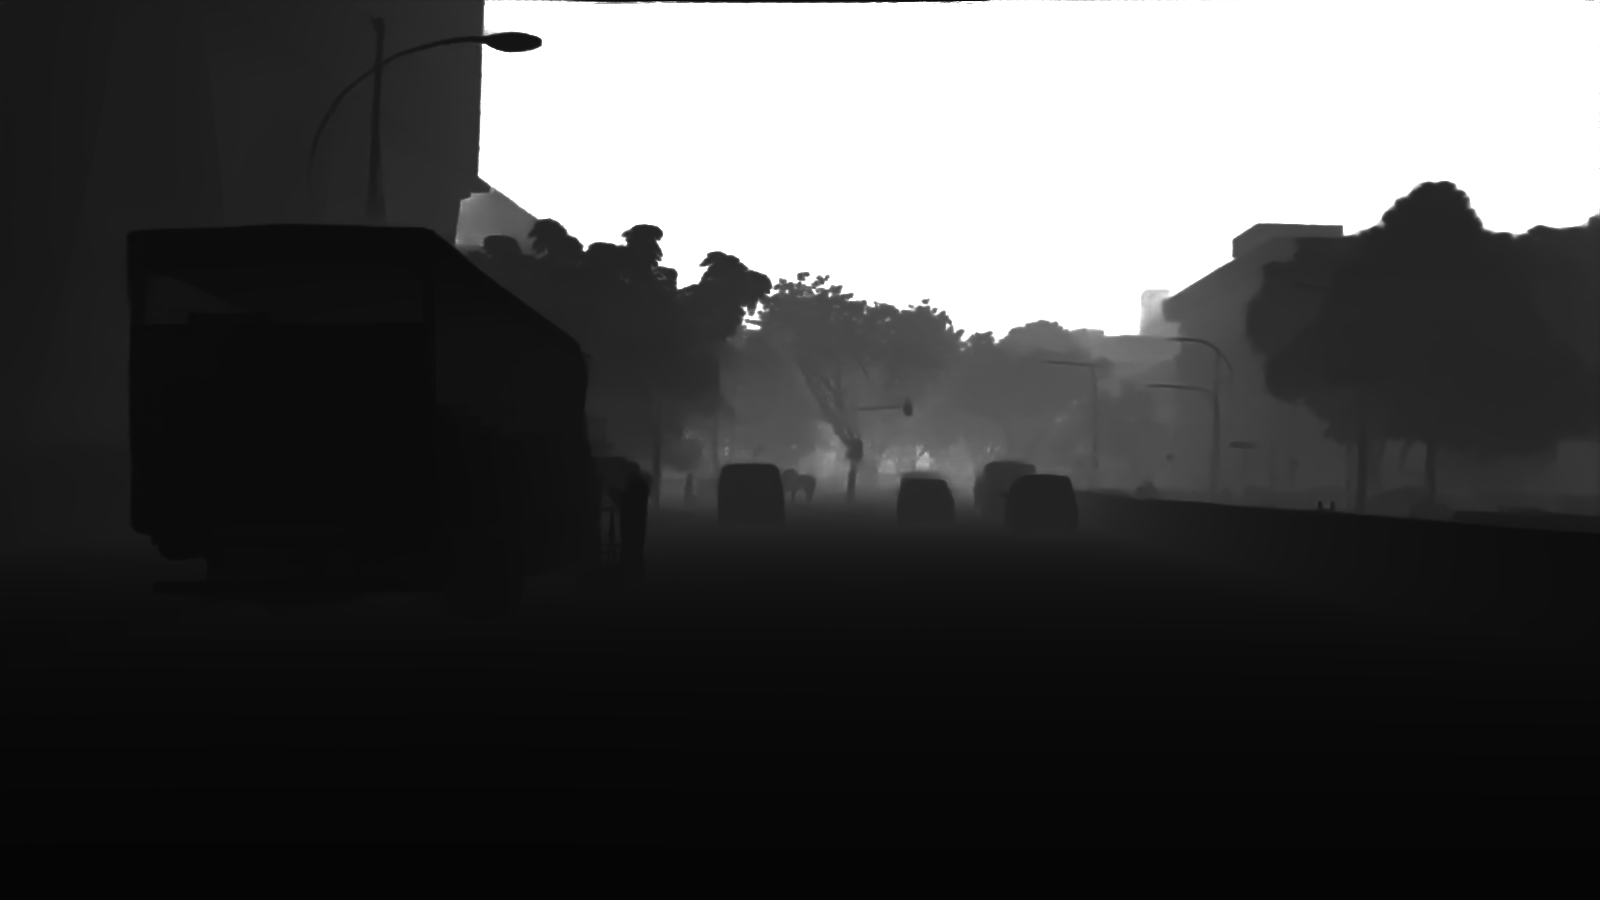

tensor(1382.6686, device='cuda:4')

In [24]:
depth_image_np = depth.detach().cpu().numpy()
depth_image_pil = Image.fromarray(depth_image_np.astype(np.float32), mode='F')
depth_image_pil.show()
focallength_px

# Compute PointCloud

In [5]:
def get_pointcloud(depth_map: np.ndarray, camera: scl.Camera, color_image: np.ndarray = None, lims: tuple = (10, 5, 30)) -> o3d.geometry.PointCloud:
    h, w = depth_map.shape

    colors = np.zeros((h, w, 3), dtype=np.float32)
    aux_xyz_3d_coords = np.zeros((h, w, 3), dtype=np.float32)
    for i in range(0, h):
        # Read all pixels pos of this row
        cam_2d_coords_3xW = np.array(
            [np.linspace(0, w - 1, num=w), i * np.ones(w), np.ones(w)]
        )
        
        cam_2d_ray3d_3xW = camera.reproject_points2d(points2d_3xN=cam_2d_coords_3xW)
        xyz_3d_coords_3xW = cam_2d_ray3d_3xW * depth_map[i, :]
        
        aux_xyz_3d_coords[i, :, 0] = xyz_3d_coords_3xW[0, :]
        aux_xyz_3d_coords[i, :, 1] = xyz_3d_coords_3xW[1, :]
        aux_xyz_3d_coords[i, :, 2] = xyz_3d_coords_3xW[2, :]

        if color_image is not None:
            colors[i, :] = color_image[i, :] / 255.0 # Normalize color 

    # non_zero_depth_mask = aux_xyz_3d_coords[:, :, 2] != 0
    pcd_points = aux_xyz_3d_coords.reshape(-1, 3)
    mask = (abs(pcd_points[:, 0]) <= lims[0]) & (abs(pcd_points[:, 1]) <= lims[1]) & (abs(pcd_points[:, 2]) <= lims[2])

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pcd_points[mask])
    if color_image is not None:
        colors = colors.reshape(-1, 3)[mask]
        pcd.colors = o3d.utility.Vector3dVector(colors)
    
    return pcd


In [54]:
vcd = core.OpenLABEL()
vcd.load_from_file(vcd_path)
scene = scl.Scene(vcd)
camera = scene.get_camera("CAM_FRONT")

point_cloud = get_pointcloud(depth_image_np, camera, color_image=image)
o3d.io.write_point_cloud(filename=f"{out_pcd_path}", pointcloud=point_cloud, write_ascii=True)

True

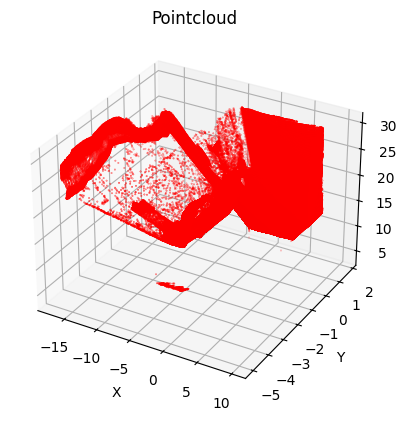

In [55]:
xyz = np.asarray(point_cloud.points)

# Crear una figura y un conjunto de ejes 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar la nube de puntos
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=0.1, c='r', marker='o')

# Etiquetas y título
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Pointcloud')

# Mostrar el gráfico
plt.show()

## Tests

### Implementación Martí

In [14]:
vcd = core.OpenLABEL()
vcd.load_from_file(vcd_path)
scene = scl.Scene(vcd)
camera = scene.get_camera("CAM_FRONT")

h, w = depth_image_np.shape
depth_dmap_coords = np.argwhere(depth_image_np != 0)
depth_pixels_dict = {(i, j): depth_image_np[i, j] / 100 for i, j in depth_dmap_coords} 

# aux_xyz_3d_coords = np.zeros_like(dmap_img, dtype=np.float32)
aux_xyz_3d_coords = np.zeros((h, w, 3), dtype=np.float32)

# Get XY 3D rays from 2D img coordinates (in the camera cs)
for j in range(0, h):
    for i in range(0, w):
        if (j, i) in depth_pixels_dict:
            # Get the intersection between depth plane and the 3D ray that passes through x, y coordinates
            cam_2d_coords_3x1 = utils.add_homogeneous_row(np.array([i, j]).reshape(2,1))
            cam_2d_ray3d_3x1 = camera.reproject_points2d(points2d_3xN=cam_2d_coords_3x1).reshape(1,3).flatten()
            cam_2d_3d_coords_3x1 = depth_pixels_dict[j, i] * cam_2d_ray3d_3x1
            cam_2d_3d_coords_4x1 = utils.add_homogeneous_row(cam_2d_3d_coords_3x1.reshape(3,1))
            cam_2d_to_lidar_3d_coords_4x1 = np.array([cam_2d_3d_coords_4x1[2, 0],  # Get z as the first element
                        -cam_2d_3d_coords_4x1[0, 0],  # Negate x for the second element
                        -cam_2d_3d_coords_4x1[1, 0]]) 
                                    
            # Fill aux array 
            aux_xyz_3d_coords[j, i][0] = cam_2d_to_lidar_3d_coords_4x1[0]
            aux_xyz_3d_coords[j, i][1] = cam_2d_to_lidar_3d_coords_4x1[1]
            aux_xyz_3d_coords[j, i][2] = cam_2d_to_lidar_3d_coords_4x1[2]
            
# Filterout those pixels whose depth is 0
non_zero_depth_mask = aux_xyz_3d_coords[:, :, 0] != 0
pcd_3d_lidar_cs = np.asarray(aux_xyz_3d_coords[non_zero_depth_mask]).T
pcd_4d_lidar_cs = utils.add_homogeneous_row(pcd_3d_lidar_cs)

point_cloud_o3d = o3d.geometry.PointCloud()
points = pcd_4d_lidar_cs.T[:,0:3] * 100
points = points[(points[:, 0] <= 40) & (abs(points[:, 1]) <= 10) & (points[:, 2] <= 5)]
point_cloud_o3d.points = o3d.utility.Vector3dVector(points)
# o3d.io.write_point_cloud(filename=f"{out_pcd_path}", pointcloud=point_cloud_o3d, write_ascii=True)


In [ ]:
xyz = np.asarray(point_cloud_o3d.points)

# Crear una figura y un conjunto de ejes 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar la nube de puntos
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=0.1, c='r', marker='o')

# Etiquetas y título
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Pointcloud')

# Mostrar el gráfico
plt.show()

### Implementación sin loops

In [ ]:
vcd = core.OpenLABEL()
vcd.load_from_file(vcd_path)
scene = scl.Scene(vcd)
camera = scene.get_camera("CAM_FRONT")

h, w = depth_image_np.shape
depth_pixel_values = depth_image_np.flatten()
print(f"depth image shape (H, W): {h, w}")

x_coords, y_coords  = np.meshgrid(np.arange(h), np.arange(w))
pixel_coords        = np.stack([y_coords.ravel(), x_coords.ravel()], axis=-1).T
print(f"pixel_coords.shape: {pixel_coords.shape} | pixel_coords: {pixel_coords}")

cam_2d_coords_3xN = utils.add_homogeneous_row(pixel_coords)
print(f"cam_2d_coords_3xN.shape: {cam_2d_coords_3xN.shape} | cam_2d_coords_3xN: {cam_2d_coords_3xN}")

cam_2d_ray3d_3xN = camera.reproject_points2d(points2d_3xN=cam_2d_coords_3xN)
print(f"cam_2d_ray3d_3xN: {cam_2d_ray3d_3xN}")


xyz_3d_coords_3xN = cam_2d_ray3d_3xN * depth_pixel_values
print(f"xyz_3d_coords_3xN.shape: {xyz_3d_coords_3xN.shape} | depth_pixel_values.shape: {depth_pixel_values.shape}")
print(f"xyz_3d_coords_3xN: {xyz_3d_coords_3xN}")


non_zero_depth_mask = xyz_3d_coords_3xN[:, 2] != 0
pcd_points  = xyz_3d_coords_3xN[non_zero_depth_mask].T
#pcd_points = aux_xyz_3d_coords.transpose(1, 2, 0).reshape(-1, 3)
pcd_points[:, 0], pcd_points[:, 1], pcd_points[:, 2] = pcd_points[:, 2], -pcd_points[:, 0], -pcd_points[:, 1]
pcd_points = pcd_points[(pcd_points[:, 0] <= 40) & (abs(pcd_points[:, 1]) <= 10) & (pcd_points[:, 2] <= 5)]

print(f"non_zero_depth_mask.shape: {non_zero_depth_mask.shape} | non_zero_depth_mask: {non_zero_depth_mask}")
print(f"pcd_points.shape: {pcd_points.shape} | pcd_points: {pcd_points}")

point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(pcd_points)
#o3d.io.write_point_cloud(filename=f"{out_pcd_path}", pointcloud=point_cloud, write_ascii=True)


In [ ]:
xyz = np.asarray(point_cloud.points)

# Crear una figura y un conjunto de ejes 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar la nube de puntos
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=0.1, c='r', marker='o')

# Etiquetas y título
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Pointcloud')

# Mostrar el gráfico
plt.show()

### Implementación H Loop

In [ ]:
vcd = core.OpenLABEL()
vcd.load_from_file(vcd_path)
scene = scl.Scene(vcd)
camera = scene.get_camera("CAM_FRONT")

h, w = depth_image_np.shape

aux_xyz_3d_coords = np.zeros((3, h, w), dtype=np.float32)
print(f"aux_xyz_3d_coords.shape: {aux_xyz_3d_coords.shape}")
for i in range(0, h):
    # Read all pixels pos of this row
    cam_2d_coords_3xW = np.array(
        [np.linspace(0, w - 1, num=w), i * np.ones(w), np.ones(w)]
    )

    cam_2d_ray3d_3xW = camera.reproject_points2d(points2d_3xN=cam_2d_coords_3xW)
    xyz_3d_coords_3xW = cam_2d_ray3d_3xW * depth_image_np[i, :]
    
    aux_xyz_3d_coords[0, i, :] = xyz_3d_coords_3xW[2, :]
    aux_xyz_3d_coords[1, i, :] = - xyz_3d_coords_3xW[0, :]
    aux_xyz_3d_coords[2, i, :] = - xyz_3d_coords_3xW[1, :]

non_zero_depth_mask = aux_xyz_3d_coords[:, :, 2] != 0
pcd_points = aux_xyz_3d_coords.transpose(1, 2, 0).reshape(-1, 3)
pcd_points = pcd_points[(pcd_points[:, 0] <= 40) & (abs(pcd_points[:, 1]) <= 10) & (pcd_points[:, 2] <= 5)]

print(f"non_zero_depth_mask.shape: {non_zero_depth_mask.shape} | non_zero_depth_mask: {non_zero_depth_mask}")
print(f"pcd_points.shape: {pcd_points.shape} | pcd_points: {pcd_points}")

point_cloud_hloop = o3d.geometry.PointCloud()
point_cloud_hloop.points = o3d.utility.Vector3dVector(pcd_points)

In [ ]:
xyz = np.asarray(point_cloud_hloop.points)

# Crear una figura y un conjunto de ejes 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar la nube de puntos
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=0.1, c='r', marker='o')

# Etiquetas y título
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Pointcloud')

# Mostrar el gráfico
plt.show()

### Implementación H, W Loops

In [ ]:
vcd = core.OpenLABEL()
vcd.load_from_file(vcd_path)
scene = scl.Scene(vcd)
camera = scene.get_camera("CAM_FRONT")

h, w = depth_image_np.shape
depth_dmap_coords = np.argwhere(depth_image_np != 0)
depth_pixels_dict = {(i, j): depth_image_np[i, j] / 100 for i, j in depth_dmap_coords} 

aux_xyz_3d_coords = np.zeros((h, w, 3), dtype=np.float32)
for j in range(0, h):
    for i in range(0, w):
        # Read all pixels pos of this row
        #cam_2d_coords_3x1 = np.array([i, j, 1.0]).reshape((3, 1))
        cam_2d_coords_3x1 = utils.add_homogeneous_row(np.array([i, j]).reshape(2,1))
        cam_2d_ray3d_3x1 = camera.reproject_points2d(points2d_3xN=cam_2d_coords_3x1).flatten()
        
        xyz_3d_coords_3x1 = cam_2d_ray3d_3x1 * depth_image_np[j, i]

        aux_xyz_3d_coords[j, i][0] = xyz_3d_coords_3x1[2]
        aux_xyz_3d_coords[j, i][1] = - xyz_3d_coords_3x1[0]
        aux_xyz_3d_coords[j, i][2] = - xyz_3d_coords_3x1[1]

non_zero_depth_mask = aux_xyz_3d_coords[:, :, 0] != 0
pcd_points = aux_xyz_3d_coords[non_zero_depth_mask]
pcd_points = pcd_points[(pcd_points[:, 0] <= 40) & (abs(pcd_points[:, 1]) <= 10) & (pcd_points[:, 2] <= 5)]
point_cloud_hwloop = o3d.geometry.PointCloud()
point_cloud_hwloop.points = o3d.utility.Vector3dVector(pcd_points)

In [ ]:
xyz = np.asarray(point_cloud_hwloop.points)

# Crear una figura y un conjunto de ejes 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar la nube de puntos
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=0.1, c='r', marker='o')

# Etiquetas y título
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Pointcloud')

# Mostrar el gráfico
plt.show()

In [ ]:
A = np.array([[0, 1, 2, 3], 
              [4, 5, 6, 7], 
              [1, 1, 1, 1]])

B = np.array([10, 11, 12, 13])

print(f"A.shape {A.shape}")
print(f"B.shape {B.shape}")
A * B

In [ ]:
A = np.array([1, 2, 3]).reshape((3, 1))
print(f"A.shape {A.shape} | A: {A}")

B = np.array([10, 11, 12])
print(f"B.shape {B.shape} | B: {B}")

print(f"A * B = {A * B}")
print(f"A.flatten() * B = {A.flatten() * B}")


# Semantic PointCloud

In [6]:
image_token     = "2940ea9eda6c4cf6b6a30a47d579cd1c" 
vcd_path        = os.path.join("../tmp/BEVDataset/mini", image_token + ".json")
raw_path        = os.path.join("../tmp/NuImagesFormatted/mini", image_token + "_raw.png")
semantic_path   = os.path.join("../tmp/NuImagesFormatted/mini", image_token + "_semantic.png")
out_pcd_path    = "../data/output/test/pcds"


# Load OpenLABEL
vcd = core.OpenLABEL()
vcd.load_from_file(vcd_path)
scene = scl.Scene(vcd)
camera = scene.get_camera("CAM_FRONT")

# Load and preprocess the image.
raw_image, _, f_px = depth_pro.load_rgb(raw_path)
#Image.fromarray(image).show()

# Load semantic mask
semantic_mask = cv2.imread(semantic_path)[:, :, 0]
#Image.fromarray(cv2.cvtColor(semantic_mask, cv2.COLOR_BGR2RGB)).show()

# Run inference.
prediction = model.infer(transform(raw_image), f_px=f_px)
depth = prediction["depth"]  # Depth in [m].
focallength_px = prediction["focallength_px"]  # Focal length in pixels.
depth_dmap = depth.cpu().detach().numpy()
#Image.fromarray(depth_dmap).show()

In [9]:
def get_segmented_pcds(depth_dmap: np.ndarray, camera: scl.Camera, seg_mask:np.ndarray, id2label:dict = None, id2dynamic: dict = None, color_image:np.ndarray = None):
    pcd = get_pointcloud(depth_dmap, camera, color_image=color_image, lims=(np.inf, np.inf, np.inf))

    pcds = []
    labels = np.unique(seg_mask)

    for l in labels:
        mask = (seg_mask == l).flatten()

        points = np.asarray(pcd.points)[mask]
        colors = np.asarray(pcd.colors)[mask]
        
        new_pcd = o3d.geometry.PointCloud()
        new_pcd.points = o3d.utility.Vector3dVector(points)
        new_pcd.colors = o3d.utility.Vector3dVector(colors)
        
        data = {"pcd": new_pcd, "id": l}
        if id2label is not None and l in id2label:
            data['label'] = id2label[l]        
        if id2dynamic is not None and l in id2dynamic:
            data['dynamic'] = id2dynamic[l]

        pcds.append(data)

    return pcds

In [11]:
from oldatasets.NuImages.nulabels import nuid2color, nuid2name, nuid2dynamic
from oldatasets.common.utils import target2image

alpha = 0.5
raw_image_float = raw_image.astype(np.float32)
semantic_mask_rgb = target2image(semantic_mask, nuid2color)
semantic_mask_rgb_float = semantic_mask_rgb.astype(np.float32)

# Aplicamos la máscara con el valor alfa
blended_image = cv2.addWeighted(raw_image_float, 1 - alpha, semantic_mask_rgb_float, alpha, 0)

segmented_pointclouds = get_segmented_pcds(depth_dmap, camera, semantic_mask, id2label=nuid2name, id2dynamic=nuid2dynamic, color_image=blended_image)
for i, pcd in enumerate(segmented_pointclouds):
    out_file_path = os.path.join(out_pcd_path, f"{pcd['label']}.pcd")
    o3d.io.write_point_cloud(filename=out_file_path, pointcloud=pcd['pcd'], write_ascii=True)


In [12]:
segmented_pointclouds

[{'pcd': PointCloud with 743908 points.,
  'id': 0,
  'label': 'background',
  'dynamic': False},
 {'pcd': PointCloud with 115751 points.,
  'id': 17,
  'label': 'vehicle.car',
  'dynamic': True},
 {'pcd': PointCloud with 15468 points.,
  'id': 23,
  'label': 'vehicle.truck',
  'dynamic': True},
 {'pcd': PointCloud with 564873 points.,
  'id': 25,
  'label': 'flat.driveable_surface',
  'dynamic': False}]